# Train a network to produce sines of 4 different frequencies and 4 different amplitudes
    - network is a single RNN node connected to a single dense readout unit
    - This network addresses a question raised by some experimental recordings in monkey motor cortex.
    - The monkey was performing an isometric task where he had to produce different force patterns (the pacman task as described in Marshall et al., 2022).
    - Some conditions required the monkey to generate sinusodal force patterns.
    - When two conditions differed only in frequency (same amplitude), neural activity in motor cortex was fairly different.
    - But when two conditions differed only in amplitude (same frequency), neural activity was fairly similar.
    - One interpretation of these results is that some other brain area (not motor cortex) is controlling the gain of motor output. Previous work has suggested that the basal ganglia is responsible.
    - My intuition is that generating sines of different frequencies requires fairly different flowfields and therefore very different patterns of activity in motor cortex.
    - But just scaling the amplitude of activity can be accomplished by a simple 'tilting' of activity (just slightly change the angle between the readout dimension and the neural activity.
    - To test this intuition, I trained a network to perform a simplified version of the pacman task and compared the activity that generated conditions of different amplitudes or frequencies.


### Model 2
    - Model gets 2 inputs, one that conveys frequency and one that conveys gain of the output
     

In [1]:
%matplotlib inline

# import modules

from pylab import *
from scipy import stats
import sklearn

import os
import scipy.io
import keras

from keras.models import Sequential
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import initializers
from keras.models import load_model
from keras import regularizers
from numpy import matlib

from keras import backend as K
import tensorflow as tf

import itertools
from sklearn.metrics.pairwise import euclidean_distances



In [2]:
# Prevent TF from accessing the GPU.
tf.config.experimental.set_visible_devices([],'GPU')

In [3]:
# define various paths

# path to trained weights
weightPath = '/Users/andrew/Documents/Projects/Churchland/BG/networks/weights/'

# where to save generated figures
figPath = '/Users/andrew/Documents/Projects/Churchland/BG/networks/figures/'

### General Parameters

In [4]:
# when does the instruction turn on? 
inputOn_Range = np.array([5, 15])

# how long does the instruction stay on? 
inputDuration_Range = np.array([5,30])

# what is the duration between when the instruction turns off and the first segment begins?
outputDelay = 5

# how long is each segment?
segmentDuration = 50

# how many segments per trial? 
numSegmentsPerTrial = 1

# total duration of end buffer (to force model return to baseline )
endBufferDuration = 20

# number if inputs
numInputs = 2

# number of output units
numOutput = 1

# number of recurrent units 
numRecurrent = 100

# number of training epochs 
numTrainingEpochs = int(1e3)

# theshold for stopping training
stopThreshold = 0.001

# hyperparameters for cortical and bg modules
activity_alpha = 1e-8
recurrentW_alpha = 1e-6
outputW_alpha = 1e-8

# std of noise used during training
noiseScale = 1e-5

### Condition parameters

In [5]:
# output frequencies
numOutputFreqs = 4
outputFrequencies = np.arange(numOutputFreqs)+1

# output gains
outputGains = np.arange(0.5,2.5,0.5)
numOutputGains = outputGains.shape[0]

# define the gains and the frequency for each condition
conditionOutput = np.concatenate((np.tile(outputFrequencies,numOutputGains)-1,
                                   (np.tile(np.arange(numOutputGains),numOutputFreqs).reshape(numOutputFreqs,numOutputGains,order = 'C').T.ravel()))).reshape(-1,2,order = 'F')
numConditions = np.shape(conditionOutput)[0]
                                        
# define input values
conditionInputs = conditionOutput + 1

In [6]:
# define a generator to produce outputs of varying lengths on each training trial

def generator(): 
    
    while True: 

        # pick a time for the input to turn on
        inputOnTime = np.random.randint(inputOn_Range[0], inputOn_Range[1])
        
        # when does input turn off?
        inputOffTime = inputOnTime + np.random.randint(inputDuration_Range[0], inputDuration_Range[1])
        
        # when does the output start? 
        outputStartTime = inputOffTime + outputDelay
        
        # what is the total duration of the trial?
        trialDuration = outputStartTime + (numSegmentsPerTrial*segmentDuration) + endBufferDuration
        
        # initialize the inputs and target (time x 2 x numConditions) and (time x 1 x numConditions)
        input = np.zeros([trialDuration, numInputs,numConditions])
        target = np.zeros([trialDuration,numOutput,numConditions])
        
        # randomly order the conditions
        CONDITIONS = np.random.permutation(numConditions)
        
        # cycle through conditions
        for n in arange(numConditions):
                           
            # plug in the appropriate input
            for i in arange(2):             
                input[inputOnTime:inputOffTime,i,n] = conditionInputs[CONDITIONS[n],i]
        
            # plug in the appropriate target
            startIdx = outputStartTime
            x = np.arange(segmentDuration)*(1/10)

            target[startIdx:(startIdx + segmentDuration),0,n] =  outputGains[conditionOutput[CONDITIONS[n],1]] * sin(x*outputFrequencies[conditionOutput[CONDITIONS[n],0]])
               
        # add a small amount of noise to the input
        input = input + (np.random.randn(trialDuration,1,numConditions) * np.sqrt(noiseScale))
                   
        # permute input and target to 1 x T x K 
        input_pmt = np.transpose(input,(2,0,1))
        target_pmt = np.transpose(target,(2,0,1))
        
        # yield input and target
        yield input_pmt, target_pmt

In [7]:
# build the model

# start with an input node to the BG RNN node 
inputs = keras.Input(shape = (None, numInputs))

# define RNN
recurrent = keras.layers.SimpleRNN(numRecurrent, activation='tanh',
           return_sequences = True,
           activity_regularizer = regularizers.l2(activity_alpha),
           recurrent_regularizer = regularizers.l2(recurrentW_alpha))

# define the output of the rnn
output = recurrent(inputs)

# define the readout unit
readout = keras.layers.Dense(numOutput,kernel_regularizer = regularizers.l2(outputW_alpha))(output)

# create the full model
model = keras.Model(inputs=inputs, outputs=[readout])


In [8]:
# define the parameters for our optimizer
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad=True)

/Users/andrew/miniconda3/envs/BG_modeling_v2/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
# compile the model
model.compile(loss = 'mean_squared_error',
             optimizer = adam,
             metrics=['accuracy'])

In [10]:
# train the model

# set up saving of the weights of each model (so we can return to the best) 
modelCheckPoint = ModelCheckpoint(weightPath + 'motorCortex_gainTask_weights.hdf5',
                                      monitor = 'loss',verbose = 0, save_best_only=True, save_weights_only = True)

# stop training early if things aren't going well
earlyStop = EarlyStopping(monitor = 'loss',min_delta = 0,patience = 500,restore_best_weights = True)

# track our minimum loss
minLoss = inf

while minLoss > stopThreshold:
    
    history = model.fit_generator(generator(), epochs = numTrainingEpochs, steps_per_epoch = 1,
                                callbacks = [modelCheckPoint,earlyStop],verbose=0)
    
    # load the weights that produced the best accuracy 
    model.load_weights(weightPath + 'motorCortex_gainTask_weights.hdf5')

    # check our minimum loss
    minLoss = np.min(history.history['loss'])

/var/folders/h4/g8hnl8017b358kqbslb6bbx40000gn/T/ipykernel_13090/1435234428.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator(), epochs = numTrainingEpochs, steps_per_epoch = 1,
2023-07-17 10:36:25.767124: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### test trained model

1/1 [==============================] - 0s 6ms/step


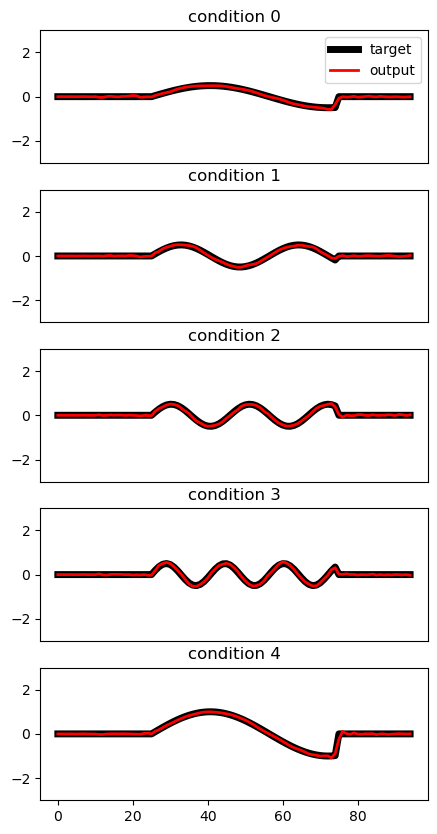

In [21]:
# generate the appropriate input for all conditions

# pick a time for the input to turn on
inputOnTime = 10

# when does input turn off?
inputOffTime = inputOnTime + 10

# when does the output start? 
outputStartTime = inputOffTime + outputDelay

# what is the total duration of the trial?
trialDuration = outputStartTime + (numSegmentsPerTrial*segmentDuration) + endBufferDuration

# initialize the inputs and target (time x 2 x numConditions) and (time x 1 x numConditions)
input = np.zeros([trialDuration, numInputs,numConditions])
target = np.zeros([trialDuration,numOutput,numConditions])

# randomly order the conditions
CONDITIONS = np.arange(numConditions)

# cycle through conditions
for n in arange(numConditions):

    # plug in the appropriate input
    for i in arange(2):             
        input[inputOnTime:inputOffTime,i,n] = conditionInputs[CONDITIONS[n],i]

    # plug in the appropriate target
    startIdx = outputStartTime
    x = np.arange(segmentDuration)*(1/10)

    target[startIdx:(startIdx + segmentDuration),0,n] =  outputGains[conditionOutput[CONDITIONS[n],1]] * sin(x*outputFrequencies[conditionOutput[CONDITIONS[n],0]])


# permute input and target to 1 x T x K 
input_pmt = np.transpose(input,(2,0,1))
target_pmt = np.transpose(target,(2,0,1))
        

# get model output
modelOutput = model.predict(input_pmt)

# and plot the model performance on the first 5 conditions (network was trained on 16 conditions)
plt.figure(figsize=(5,10))
for i in arange(5):
    plt.subplot(5,1,i+1)
    plt.plot(target[:,0,i],color = 'k',linewidth=5, label='target');
    plt.plot(modelOutput[i,:,0], color = 'r',linewidth = 2, label='output');
    plt.ylim([-3, 3]);
    plt.title('condition ' + str(i))

    if i==0:
        plt.legend()
    if i < 4:
        plt.tick_params('x',labelbottom=False,bottom=False)

# save figure
plt.savefig(figPath + 'trainedModelOutput.pdf');


### calculate performance
- note that this is training performance, as there were not any held-out conditions

In [22]:
# reshape target and model output to be CT x 1
target_reshape = target.reshape((-1,1),order = 'F')
output_reshape = modelOutput.T.reshape((-1,1),order = 'F')

# calculate the total sum of squares and residual sum of squares
SS_tot = np.sum( (target_reshape - np.mean(target_reshape) )**2)

# calculate the sum of the residuals 
SS_res = np.sum( (target_reshape - output_reshape )**2)

# display R^2 
R2 = 1 - (SS_res/SS_tot)

# display
print('\n R2 training performance: ' + str(R2))


 R2 training performance: 0.9977196100510525


### pull out model rates 
- rates will be a T x N x C tensor

In [23]:
# define a function that gives returns the rates of all of the layers given a input
inp = model.layers[0].input
outputs = [layer.output for layer in model.layers][1:]   
functors = [K.function([inp], [out]) for out in outputs]

# get outputs
rates = [func([input_pmt]) for func in functors]

# pull out the rates from the recurrent layer
rates = np.squeeze(rates[0]).transpose((1,2,0))


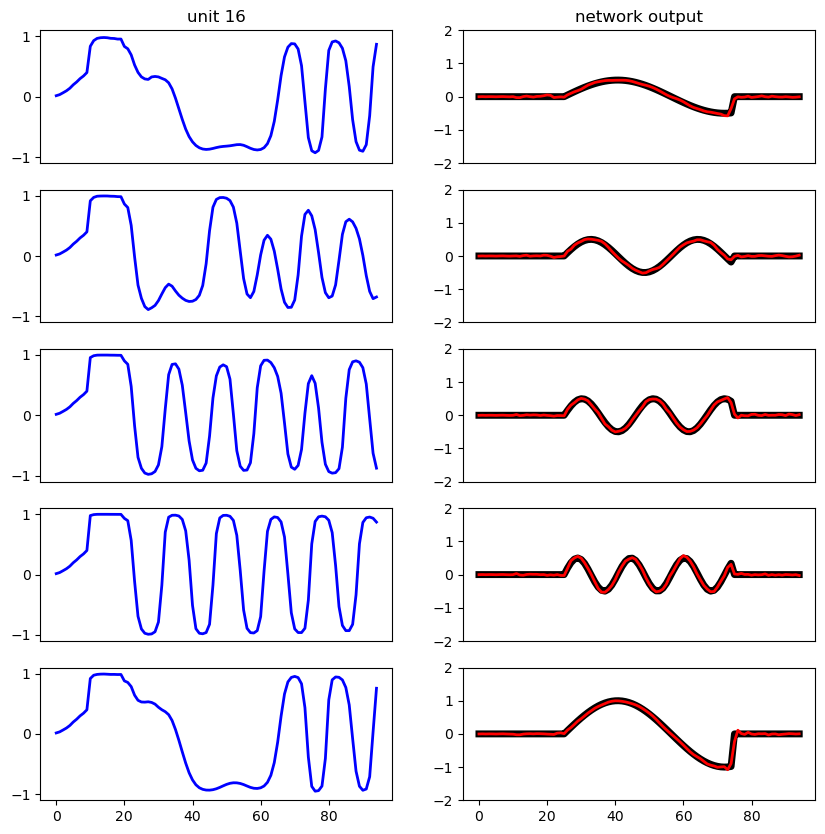

In [39]:
# plot an example unit for 5 conditions 

neuronIdx = np.random.randint(0,high = numRecurrent)
idx=0

plt.figure(figsize=(10,10))
for i in arange(5):
    idx += 1 
    plt.subplot(5,2,idx)
    plt.plot(rates[:,neuronIdx,i], color = 'b', linewidth = 2)
    plt.ylim([-1.1,1.1]);

    if i < 4:
        plt.tick_params('x',labelbottom=False,bottom=False)


    if i == 0:
        title('unit ' + str(neuronIdx))
    
    idx += 1
    plt.subplot(5,2,idx)
    plt.plot(target[:,0,i],color = 'k',linewidth=5);
    plt.plot(modelOutput[i,:,0], color = 'r',linewidth = 2);
    plt.ylim([-2, 2]);

    if i == 0:
        title('network output');

    if i < 4:
        plt.tick_params('x',labelbottom=False,bottom=False)

# save figure
plt.savefig(figPath + 'exampleUnit.pdf');



### For each unit, calculate pairwise correlations between conditions

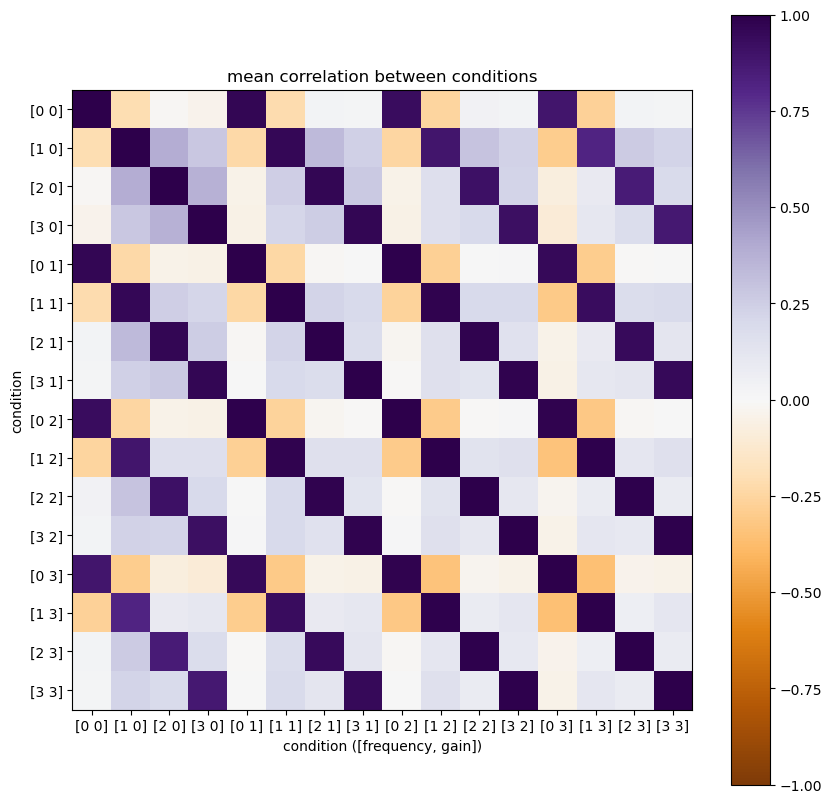

In [84]:
# times where the network produces an output
outputTimes = np.arange(outputStartTime, trialDuration-endBufferDuration)

# initialize a numConds x numConds x numNeurons tensor to hold correlations
allCorr = np.zeros((numConditions,numConditions,numRecurrent)) + np.nan

# cycle through neurons
for ii in range(numRecurrent):

    # grab our rates,
    unitRates = rates[outputTimes,ii,:].squeeze()

    # calculate correlations
    allCorr[:,:,ii] = np.corrcoef(unitRates.T)

# take average across conditions
corrMean = np.mean(allCorr,axis=2)

# plot
plt.figure(figsize=(10,10));
plt.imshow(corrMean,cmap='PuOr',vmin=-1,vmax=1)
plt.colorbar();

# add labels
plt.xticks(ticks=np.arange(16),labels= [str(x) for x in conditionOutput]);
plt.yticks(ticks=np.arange(16),labels= [str(x) for x in conditionOutput]);

plt.xlabel('condition ([frequency, gain])');
plt.ylabel('condition');
plt.title('mean correlation between conditions');

# save figure
plt.savefig(figPath + 'pairwiseConditionCorrelation.pdf');


### The plot above makes it clear that a given neuron's activity pattern does not change much during conditions of different amplitudes

### But maybe the range is different?
    - for each neuron calculate the absolute difference between the ranges of different conditions


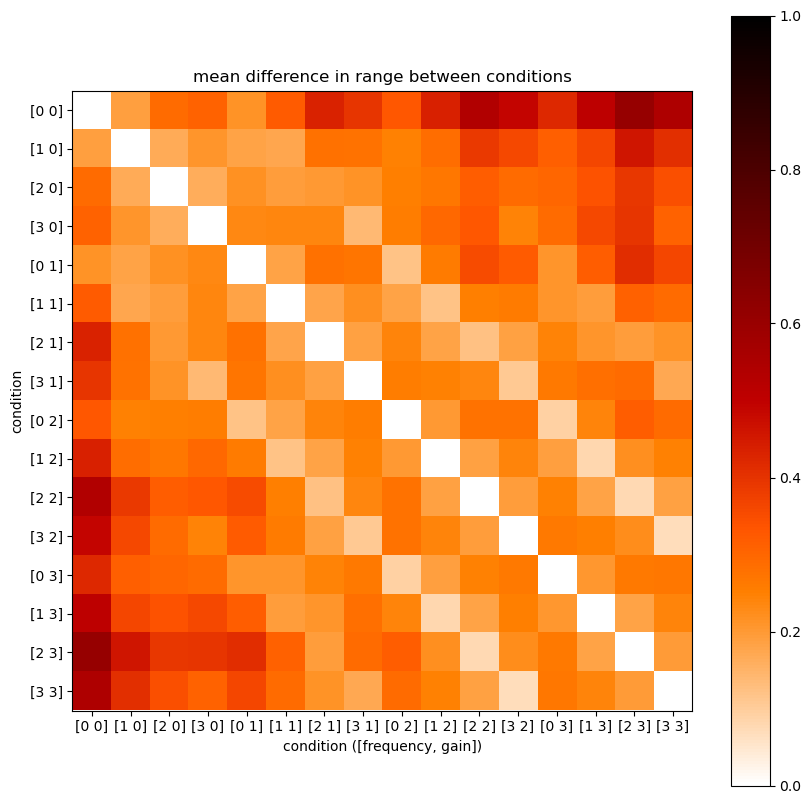

In [85]:
# initialize a numConds x numConds x numNeurons tensor to hold ranges
allRange = np.zeros((numConditions,numConditions,numRecurrent)) + np.nan

# cycle through neurons
for ii in range(numRecurrent):

    # grab our rates,
    unitRates = rates[outputTimes,ii,:].squeeze()

    # calculate ranges
    unitRange = list(np.ptp(unitRates,axis=0))

    # calculate pairwise difference in ranges
    rangeDiff =[abs(x-y) for x in unitRange for y in unitRange]
    allRange[:,:,ii] = np.array(rangeDiff).reshape(16,16,order='F');


# take average across conditions
rangeMean = np.mean(allRange,axis=2)

# plot
plt.figure(figsize=(10,10));
plt.imshow(rangeMean,cmap='gist_heat_r',vmin=0,vmax=1)
plt.colorbar();

# add labels
plt.xticks(ticks=np.arange(16),labels= [str(x) for x in conditionOutput]);
plt.yticks(ticks=np.arange(16),labels= [str(x) for x in conditionOutput]);

plt.xlabel('condition ([frequency, gain])');
plt.ylabel('condition');
plt.title('mean difference in range between conditions');

# save figure
plt.savefig(figPath + 'pairwiseConditionRangeDifference.pdf');

### Run PCA

In [86]:
# import pca
from sklearn.decomposition import PCA

# reshape rates to be CT x N
ratesForPCA = rates[20:80,:,:].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')

# fit  pca model
pca = PCA(n_components = numRecurrent)
pca.fit(ratesForPCA);
proj = pca.transform(rates.transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F'))

# reshape projections to be T x C x K 
proj = proj.reshape((-1,numConditions,numRecurrent),order = 'F')

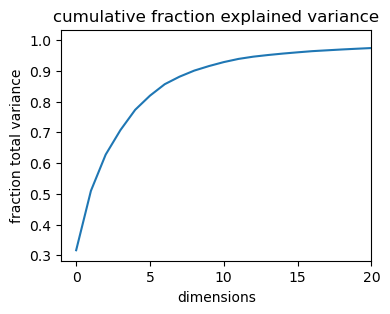

In [91]:
# plot the percent variance of each dimension
pctExpVar = pca.explained_variance_ratio_
fig = plt.figure(figsize = (4,3))
plt.plot(np.cumsum(pctExpVar))
plt.xlim(-1,20);
plt.title('cumulative fraction explained variance');
plt.xlabel('dimensions');
plt.ylabel('fraction total variance');

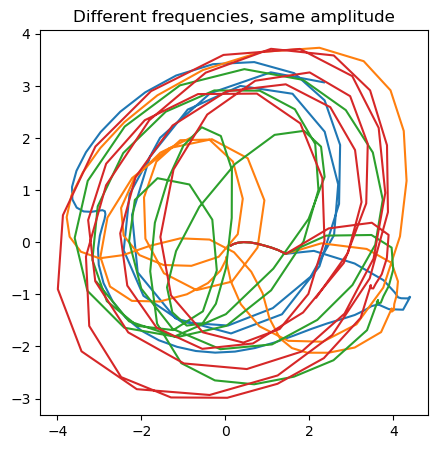

In [95]:
# plot projections of 4 conditions that differ in amplitude, but not frequency 

# first, find our conditions 
idx = np.argwhere(conditionOutput[:,1]==1)

# set up figure
fig = plt.figure(figsize = (5,5))
plt.title('Different frequencies, same amplitude')

# plot projections
plot(proj[:,idx,0].squeeze(),proj[:,idx,1].squeeze());

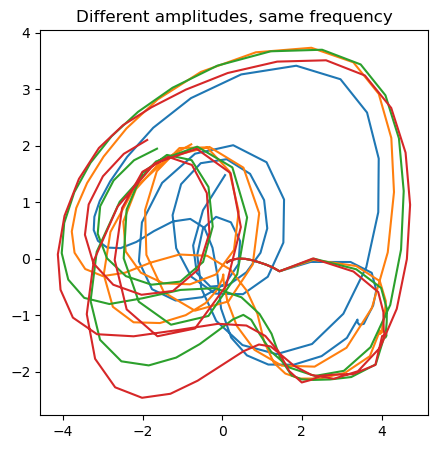

In [96]:
# plot projections of 4 conditions that differ in frequency, but not amplitude 

# first, find our conditions 
idx = np.argwhere(conditionOutput[:,0]==1)


# set up figure
fig = plt.figure(figsize = (5,5))
plt.title('Different amplitudes, same frequency')

# plot projections
plot(proj[:,idx,0].squeeze(),proj[:,idx,1].squeeze());

### Just looking at the two PC plots above, it's clear that there are substantial differences between conditions that share an amplitude, but not conditions that share a frequency.

### Calculate the mean pairwise distance between pairs of conditions that differ in frequency or amplitude

In [105]:
# calculate the pairwise distance between the neural activity of each condition, at each point in time 

# initialize tensor (C x T x C) to hold values
neuralDist = np.zeros((numConditions,outputTimes.shape[0],numConditions)) + np.nan

# length of times in this analysis
numTimes = outputTimes.shape[0]

# cycle through times
for idx,t in enumerate(outputTimes):
    
    # pull out the neural activity for all conditions at this time
    X = rates[t,:,:].squeeze()
    
    # take pairwise distance between all conditions
    tempD = euclidean_distances(X.T,X.T)
    
    # NaN-out the diagonal 
    tempD[np.diag_indices(numConditions)] = np.nan
    
    # add to larger tensor
    neuralDist[:,idx,:] = tempD

In [106]:
# calculate the mean distance between pairs of conditions that share a frequency
sameFreqMean = np.zeros((numOutputFreqs,numTimes))
for f in arange(numOutputFreqs):
    
    # pull out our indices
    idx = np.argwhere(conditionOutput[:,0]==f).ravel()
    
    # get the indices we want to compare
    x = idx
    y = np.arange(numTimes)
    z = idx
    
    # pull out the distances we care about
    tempD = neuralDist[np.ix_(x,y,z)]
    
    # calculate the grand mean between these conditions 
    sameFreqMean[f,:] = np.nanmean(np.nanmean(tempD,axis = 0),axis = 1)
 
# take the mean across all frequency groups
sameFreqMean = sameFreqMean.mean(axis = 0)

# calculate the mean distance between pairs of conditions that share an amplitude
sameAmpMean = np.zeros((numOutputGains,numTimes))
for g in arange(numOutputGains):
    
    # pull out our indices
    idx = np.argwhere(conditionOutput[:,1]==g).ravel()
    
    # don't quite understand why I still need to do this 
    x = idx
    y = np.arange(numTimes)
    z = idx
    
    # pull out the distances we care about
    tempD = neuralDist[np.ix_(x,y,z)]
    
    # calculate the grand mean between these conditions
    sameAmpMean[g,:] = np.nanmean(np.nanmean(tempD,axis = 0),axis = 1)
    
# take the mean across all amplitude groups
sameAmpMean = sameAmpMean.mean(axis = 0)

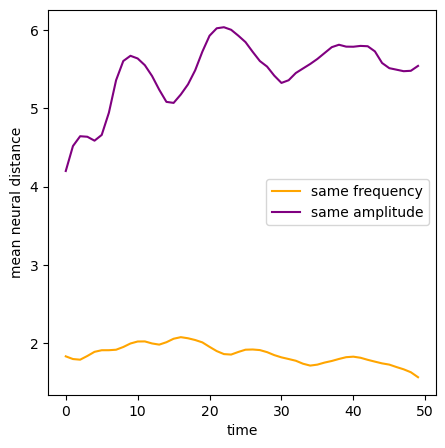

In [107]:
# plot the mean distances calculated above
fig = plt.figure(figsize = (5,5));
plt.plot(sameFreqMean,color = 'orange');
plt.plot(sameAmpMean,color = 'purple');
plt.xlabel('time');
plt.ylabel('mean neural distance');
plt.legend(['same frequency','same amplitude']);

### Group conditions by their output

/var/folders/h4/g8hnl8017b358kqbslb6bbx40000gn/T/ipykernel_13090/2351282107.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cMap = matplotlib.cm.get_cmap('gnuplot')


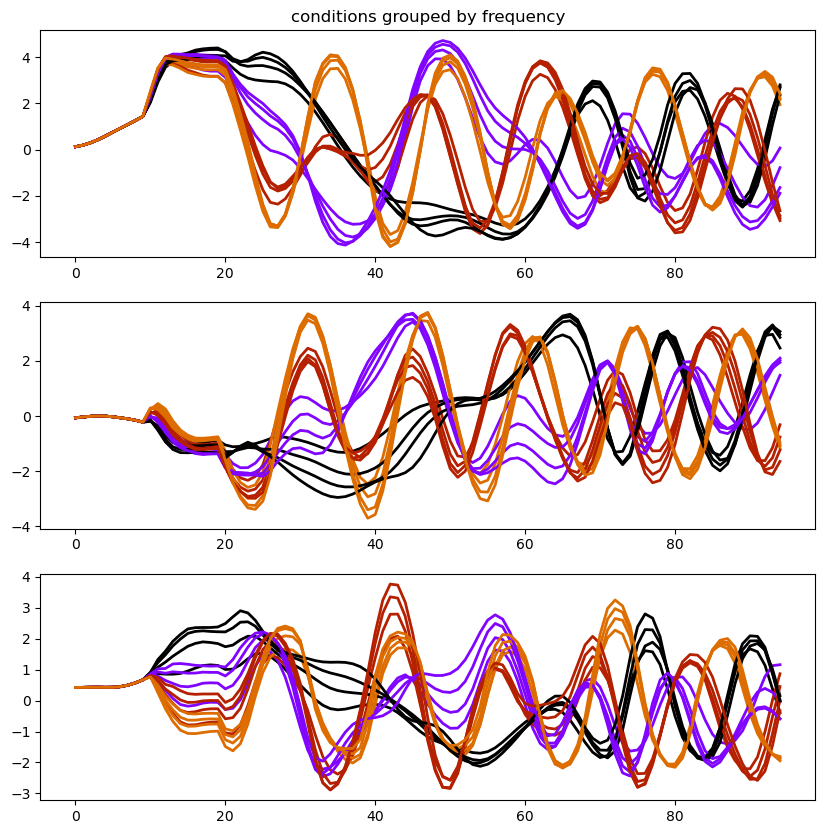

In [109]:
# First, group conditions by frequency

# chooose a colormap (and create a 'norm' object to make defining the colors easier)
cMap = matplotlib.cm.get_cmap('gnuplot')
norm = matplotlib.colors.Normalize(vmin=0, vmax = numOutputFreqs)


# PCs to plot
plotDims = np.arange(0,3)
plt.figure(figsize = (10,10))


for i in plotDims:
    
    plt.subplot(plotDims.shape[0],1,i+1-plotDims[0])
    for t in arange(numConditions):       
        plt.plot(proj[:,t,i],linewidth = 2,color = cMap(norm(conditionOutput[t,0])));
        
    if i==0:
        plt.title('conditions grouped by frequency');
    



/var/folders/h4/g8hnl8017b358kqbslb6bbx40000gn/T/ipykernel_13090/2840675730.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cMap = matplotlib.cm.get_cmap('ocean')


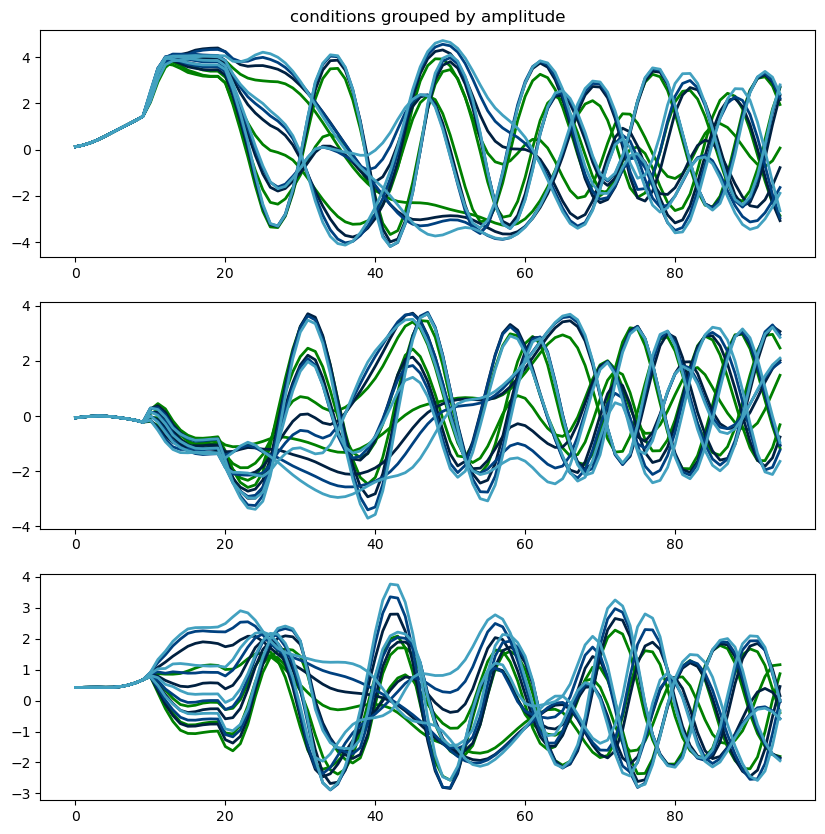

In [110]:
# First, group conditions by amplitude

# chooose a colormap (and create a 'norm' object to make defining the colors easier)
cMap = matplotlib.cm.get_cmap('ocean')
norm = matplotlib.colors.Normalize(vmin=0, vmax = numOutputGains)


# PCs to plot
plotDims = np.arange(0,3)
plt.figure(figsize = (10,10))

for i in plotDims:
    
    plt.subplot(plotDims.shape[0],1,i+1-plotDims[0])
    for t in arange(numConditions):       
        plt.plot(proj[:,t,i],linewidth = 2,color = cMap(norm(conditionOutput[t,1])));
        
    if i==0:
        plt.title('conditions grouped by amplitude');

## Summary
    - In a single network, conditions that differ in amplitude (even substantially) don't require substantially different patterns of neural activity.
    - On the other hand, generating conditions that differ in frequency probably do require very different patterns of neural activity.
    - Generating outputs of different frequencies require different flowfields.
    - When we see that outputs of different amplitudes have relatively small effects on activity in motor cortex, we should not assume that some other brain area is controlling the gain of the output. 'Gain-related signals' just don't need to be prominent for the network to generate different outputs.